In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
from langdetect import detect 
import html
pd.reset_option('all')

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_4643/450422142.py:7: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_4643/450422142.py:7: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


## Raw data

- score: number of upvotes minus number of downvotes
- link_id (for comments): id of the submission to which the comment responded

In [2]:
submissions_raw = pd.read_csv("data/raw_data/self_i_submissions.csv")
comments_raw = pd.read_csv("data/raw_data/self_i_comments.csv")

In [3]:
submissions_raw.head()

,id,created,author,score,title,selftext,num_comments,link
0,70n85,2008-09-10 04:30,u/[deleted],1,A good site for sobriety help,NaN,0,https://www.reddit.com/r/selfimprovement/comme...
1,70n89,2008-09-10 04:30,u/[deleted],1,An excellent site for workout information,NaN,0,https://www.reddit.com/r/selfimprovement/comme...
2,72lyg,2008-09-21 00:29,u/d2kd3k,3,Trying to fit some workout into your schedule?...,NaN,0,https://www.reddit.com/r/selfimprovement/comme...
3,7p4xg,2009-01-12 09:07,u/kittenone,0,The time to get started is NOW!!!,NaN,1,https://www.reddit.com/r/selfimprovement/comme...
4,7pe80,2009-01-13 08:59,u/kittenone,1,Someday?,NaN,0,https://www.reddit.com/r/selfimprovement/comme...


In [4]:
comments_raw.head()

,id,link_id,created,author,score,body,link
0,c06zjsz,t3_7p4xg,2009-01-12 09:08,u/[deleted],1,[deleted],https://www.reddit.com/r/selfimprovement/comme...
1,c074ueq,t3_7qsxn,2009-01-19 07:11,u/[deleted],1,[deleted],https://www.reddit.com/r/selfimprovement/comme...
2,c076tjv,t3_7rgv5,2009-01-21 16:21,u/HolisticResources,1,Have you ever dreamed of becoming the presiden...,https://www.reddit.com/r/selfimprovement/comme...
3,c07ccc8,t3_7tae6,2009-01-29 02:50,u/[deleted],1,[deleted],https://www.reddit.com/r/selfimprovement/comme...
4,c07w5qr,t3_809sg,2009-02-25 16:17,u/kinkycat,1,"wow, great article",https://www.reddit.com/r/selfimprovement/comme...


## Data Cleaning

### Missing values

In [5]:
def remove_missing_data(raw_df, column):
    '''
    Filters all entries that have [removed] or [deleted] in their body/self 
    text column (as applicable). Also filters NaN values.
    
    Input: 
        - raw_df: Pandas dataframe
        - column: Target column to look for missing values
    
    Returns:
        - Cleaned dataframe
    '''

    print("DataFrame shape before cleaning:", raw_df.shape)

    #Remove rows with values of "[removed]" or "[deleted]" on body/self text
    to_filter = ["[removed]", "[deleted]", "\[deleted\]"]
    mask = ~raw_df[column].isin(to_filter)
    filtered_df = raw_df[mask]

    print("DataFrame shape after filtering removed values:", 
                                                 filtered_df.shape)
    
    #Filter NaN
    filtered_df = filtered_df.dropna(subset=[column])
    print("DataFrame shape after filtering NaN values:", filtered_df.shape)

    return filtered_df

In [6]:
submissions_filtered1 = remove_missing_data(submissions_raw, "selftext")
submissions_filtered1

DataFrame shape before cleaning: (185945, 8)
DataFrame shape after filtering removed values: (125236, 8)
DataFrame shape after filtering NaN values: (118309, 8)


,id,created,author,score,title,selftext,num_comments,link
97,8w6db,2009-06-27 07:48,u/thenewhustle,0,Free Ebooks,The Master Key System\nAs a Man Thinketh\nThe ...,0,https://www.reddit.com/r/selfimprovement/comme...
99,8wd8w,2009-06-28 06:30,u/thenewhustle,0,How To Embrace Failure To Empower Your Future,A very powerful message on how to get back up ...,0,https://www.reddit.com/r/selfimprovement/comme...
142,97m4m,2009-08-04 21:37,u/hivetyrant,1,Self Confidence: The Strength We All Have,"Do you have a strong voice, or a well-built fr...",0,https://www.reddit.com/r/selfimprovement/comme...
188,a35f5,2009-11-11 01:05,u/mike-l,1,Flight of the Feathered Serpent Book Trailer,Trailer for an amazing book published decades ...,1,https://www.reddit.com/r/selfimprovement/comme...
262,hk5r2,2011-05-25 17:27,u/[deleted],1,What cures absentmindedness?,I had an appointment today with the dentist. O...,3,https://www.reddit.com/r/selfimprovement/comme...
...,...,...,...,...,...,...,...,...
185939,18vjbh2,2023-12-31 16:57,u/oxarep,2,Is it possible to learn all those things?,"Hi, im a teenager and im starving for knowlodg...",6,https://www.reddit.com/r/selfimprovement/comme...
185940,18vjhqe,2023-12-31 17:06,u/AnimeYumi,1,Sweets! 😩,"Pretty common problem I know, but seriously ho...",4,https://www.reddit.com/r/selfimprovement/comme...
185941,18vjnoo,2023-12-31 17:15,u/MLP-Badger,3,How can I make myself more attractive?,"So I’ve done physical training extensively, I’...",6,https://www.reddit.com/r/selfimprovement/comme...
185942,18vk1ez,2023-12-31 17:36,u/spiritual_payments,1,"Happy new year, how do I begin?","So idk but I just felt like complaining here, ...",0,https://www.reddit.com/r/selfimprovement/comme...


In [7]:
comments_filtered1 = remove_missing_data(comments_raw, "body")
comments_filtered1

DataFrame shape before cleaning: (1292476, 7)
DataFrame shape after filtering removed values: (1186139, 7)
DataFrame shape after filtering NaN values: (1186117, 7)


,id,link_id,created,author,score,body,link
2,c076tjv,t3_7rgv5,2009-01-21 16:21,u/HolisticResources,1,Have you ever dreamed of becoming the presiden...,https://www.reddit.com/r/selfimprovement/comme...
4,c07w5qr,t3_809sg,2009-02-25 16:17,u/kinkycat,1,"wow, great article",https://www.reddit.com/r/selfimprovement/comme...
7,c0a117d,t3_8pjlk,2009-06-03 14:18,u/robinbal,1,Break up your goals into small bite size piece...,https://www.reddit.com/r/selfimprovement/comme...
8,c0a1rqj,t3_8pjlk,2009-06-04 09:52,u/marvin566,1,Good advice: Most goals from new years resolut...,https://www.reddit.com/r/selfimprovement/comme...
9,c0a43vx,t3_8qhqj,2009-06-07 09:43,u/robinbal,2,Check against everything you do in a regular d...,https://www.reddit.com/r/selfimprovement/comme...
...,...,...,...,...,...,...,...
1292471,kfrnglf,t3_18ve7f5,2023-12-31 17:49,u/throwaway_6835,2,God dammit bro I’m normally on the other end o...,https://www.reddit.com/r/selfimprovement/comme...
1292472,kfrnjdn,t3_18uxyio,2023-12-31 17:50,u/thosepinkclouds,1,I love DG,https://www.reddit.com/r/selfimprovement/comme...
1292473,kfrohp2,t3_18viiy7,2023-12-31 17:57,u/plytime18,1,I was the same. \n\nTrust me.\n\nWhen you are...,https://www.reddit.com/r/selfimprovement/comme...
1292474,kfrojp4,t3_18vjhqe,2023-12-31 17:57,u/AnimeYumi,1,Thank you for your input!\n\nI think fruits wi...,https://www.reddit.com/r/selfimprovement/comme...


### Duplicates

In [8]:
submissions_filtered2 = submissions_filtered1.drop_duplicates(subset=['selftext'])
comments_filtered2 = comments_filtered1.drop_duplicates(subset=['body'])

print("Submissions df shape before filtering duplicates:", 
                             submissions_filtered1.shape)
    
print("Submissions df shape after filtering duplicates:", 
                             submissions_filtered2.shape)

print("Comments df shape before filtering duplicates:", 
                             comments_filtered1.shape)
    
print("Comments df shape after filtering duplicates:", 
                             comments_filtered2.shape)


Submissions df shape before filtering duplicates: (118309, 8)
Submissions df shape after filtering duplicates: (117488, 8)
Comments df shape before filtering duplicates: (1186117, 7)
Comments df shape after filtering duplicates: (1097545, 7)


### Clean text 

In [9]:
#https://www.w3schools.com/python/ref_string_translate.asp
#https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string

def clean_text(s):
    '''
    Cleans text
    
        Inputs:
            - s (string)
            
        Returns:
            - cleaned string
    '''

    # Decode HTML entities (e.g., &amp;#x200B)
    text = html.unescape(s)

    # Decode again for any remaining HTML entities like &#x200B;
    text = html.unescape(text)
    
    # Remove links
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove zero-width spaces explicitly
    text = text.replace('\u200B', '') 

    # Remove numbers at the end of the string
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Remove line breaks
    text = text.replace('\n', ' ').replace('\r', ' ')

    # Collapse multiple spaces into a single space
    text = re.sub(r'\s+', ' ', text).strip()

    # Lowercase
    text = text.lower()

    # Remove unnecessary whitespace
    return text.strip()

submissions_filtered2["cleaned_text"] = submissions_filtered2["selftext"].apply(lambda x: clean_text(x))
comments_filtered2["cleaned_text"] = comments_filtered2["body"].apply(lambda x: clean_text(x))

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_4643/219844267.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered2["cleaned_text"] = submissions_filtered2["selftext"].apply(lambda x: clean_text(x))
/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_4643/219844267.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_filtered2["cleaned_text"] = comments_filtered2["body"].apply(lambda x: clean_text(x))


### Delete very short texts

In [10]:
#Create column with word count to identify short texts
submissions_filtered2['word_count'] = submissions_filtered2['cleaned_text'].apply(lambda x: len(x.split()))
comments_filtered2['word_count'] = comments_filtered2['cleaned_text'].apply(lambda x: len(x.split()))

#Filter
print("Submissions shape before dropping short texts:", submissions_filtered2.shape)
submissions_filtered3 = submissions_filtered2[submissions_filtered2.word_count >= 50]
print("Submissions shape after dropping short texts:", submissions_filtered3.shape)

print("Comments shape before dropping short texts:", comments_filtered2.shape)
comments_filtered3 = comments_filtered2[comments_filtered2.word_count >= 50]
print("Comments shape after dropping short texts:", comments_filtered3.shape)

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_4643/2268340447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered2['word_count'] = submissions_filtered2['cleaned_text'].apply(lambda x: len(x.split()))


Submissions shape before dropping short texts: (117488, 10)
Submissions shape after dropping short texts: (97809, 10)
Comments shape before dropping short texts: (1097545, 9)
Comments shape after dropping short texts: (407558, 9)


/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_4643/2268340447.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_filtered2['word_count'] = comments_filtered2['cleaned_text'].apply(lambda x: len(x.split()))


### Remove non-english posts

In [11]:
def checks_language(text):
    '''
    Checks if the language of the text is english or not
    
        Inputs:
            - s (string)
            
        Returns:
            - Boolean (True if text is in english)
    '''

    #If there's a problem with the text, simply return False
    try: 
        lang = detect(text)
    except:
        return False 
    
    if lang == "en":
        return True
    return False

submissions_filtered3['in_english'] = submissions_filtered3['selftext'].apply(lambda x: checks_language(x))
comments_filtered3['in_english'] = comments_filtered3['body'].apply(lambda x: checks_language(x))

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_4643/271052167.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered3['in_english'] = submissions_filtered3['selftext'].apply(lambda x: checks_language(x))
/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_4643/271052167.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_filtered3['in_english'] = comments_filtered3['body'].apply(lambda x: checks_language(x))


Save posts classified as non-english in separate file to manually inspect

In [12]:
not_english_s = submissions_filtered3[submissions_filtered3.in_english == False][["selftext", "id"]]
not_english_s.to_csv("outputs/not_english_s.csv")

not_english_c = comments_filtered3[comments_filtered3.in_english == False][["body", "id"]]
not_english_c.to_csv("outputs/not_english_c.csv")

Model worked very good. Filter them 

In [13]:
submissions_filtered4 = submissions_filtered3[submissions_filtered3.in_english]
comments_filtered4 = comments_filtered3[comments_filtered3.in_english]

Delete specific posts identified as spam in later stages of the project (iterative improvement)

In [14]:
def filters_df(input_df, column, to_remove):
    '''
    Filters DataFrame based on given values

    Input:
        - input_df
        - column: column to search given values
        - to_remove (list): values to remove

    Output: 
        Filtered df
    '''

    mask = ~input_df[column].isin(to_remove)
    filtered_df = input_df[mask]

    #Check for deleted rows

    num_rows_before = input_df.shape[0]
    num_rows_after = filtered_df.shape[0]

    print("{} rows deleted. {} rows left".format((num_rows_before - num_rows_after), num_rows_after) )
    
    return filtered_df


In [15]:
to_remove = ["jwe64x5", "3a12at", "jtww4hd"]

#Apply function in two dataframes to make it a workflow in which new ids
#can be easily added later if needed without needing to change much code 
submissions_filtered5 = filters_df(submissions_filtered4, "id", to_remove)
comments_filtered5 = filters_df(comments_filtered4, "id", to_remove)

1 rows deleted. 97797 rows left
2 rows deleted. 407475 rows left


## Data engineering

### Combine submissions and comments

In [16]:
#Create column to identify them later
submissions_filtered5["type"] = "submission"
comments_filtered5["type"] = "comment"

#Concatenate
submissions_new = submissions_filtered5.rename(columns={'selftext': 'body'}, inplace=False)
complete_data = pd.concat([submissions_new, comments_filtered5], ignore_index=True)
complete_data


/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_4643/3335232358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered5["type"] = "submission"
/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_4643/3335232358.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_filtered5["type"] = "comment"


,id,created,author,score,title,body,num_comments,link,cleaned_text,word_count,in_english,type,link_id
0,hk5r2,2011-05-25 17:27,u/[deleted],1,What cures absentmindedness?,I had an appointment today with the dentist. O...,3.0,https://www.reddit.com/r/selfimprovement/comme...,i had an appointment today with the dentist ov...,64,True,submission,NaN
1,iqimz,2011-07-15 11:15,u/dustinsmusings,3,Do you use affirmations to improve your thinki...,"I created this site several months ago, and I ...",0.0,https://www.reddit.com/r/selfimprovement/comme...,i created this site several months ago and i s...,116,True,submission,NaN
2,pfzt5,2012-02-08 01:40,u/aeoz,6,Announcement.,Hello everyone.\n\nI have recently took over t...,4.0,https://www.reddit.com/r/selfimprovement/comme...,hello everyone i have recently took over this ...,194,True,submission,NaN
3,pk714,2012-02-10 19:16,u/[deleted],1,Love yourself or you'll lose yourself.,"I grew up with body dysmorphia, eating disorde...",0.0,https://www.reddit.com/r/selfimprovement/comme...,i grew up with body dysmorphia eating disorder...,581,True,submission,NaN
4,q0q8x,2012-02-22 03:24,u/[deleted],1,"So far along, so far yet to go.",I have to ask- when do you get to a point wher...,0.0,https://www.reddit.com/r/selfimprovement/comme...,i have to ask when do you get to a point where...,553,True,submission,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
505267,kfrj0t8,2023-12-31 17:18,u/FastNovel7497,1,NaN,"Be prepared, someday you’re gonna die no matte...",NaN,https://www.reddit.com/r/selfimprovement/comme...,be prepared someday youre gonna die no matter ...,314,True,comment,t3_18v4lhr
505268,kfrmtn3,2023-12-31 17:45,u/eggbunyo,1,NaN,"grow up, if you think external validation is h...",NaN,https://www.reddit.com/r/selfimprovement/comme...,grow up if you think external validation is ho...,68,True,comment,t3_18rb2vj
505269,kfrndk0,2023-12-31 17:49,u/eggbunyo,1,NaN,don’t you think it’s convenient that you’ve c...,NaN,https://www.reddit.com/r/selfimprovement/comme...,dont you think its convenient that youve convi...,59,True,comment,t3_18rb2vj
505270,kfrohp2,2023-12-31 17:57,u/plytime18,1,NaN,I was the same. \n\nTrust me.\n\nWhen you are...,NaN,https://www.reddit.com/r/selfimprovement/comme...,i was the same trust me when you are older its...,89,True,comment,t3_18viiy7


### Create year and month columns

In [17]:
def extract_time(date_string):
    '''
    Extracts year and month of publication from the "created column
    
    Input:
        - date_string: date and hour of publication
        
    Returns:
        (tuple): year and date of publication'''
    date_object = datetime.strptime(date_string, "%Y-%m-%d %H:%M")

    return date_object.year, date_object.month

complete_data[['year', 'month']] = complete_data['created'].apply\
                                           (lambda x: pd.Series(extract_time(x)))

## Exploratory Data Analysis

### Documents' length

Average number of words: 157.3654506879463


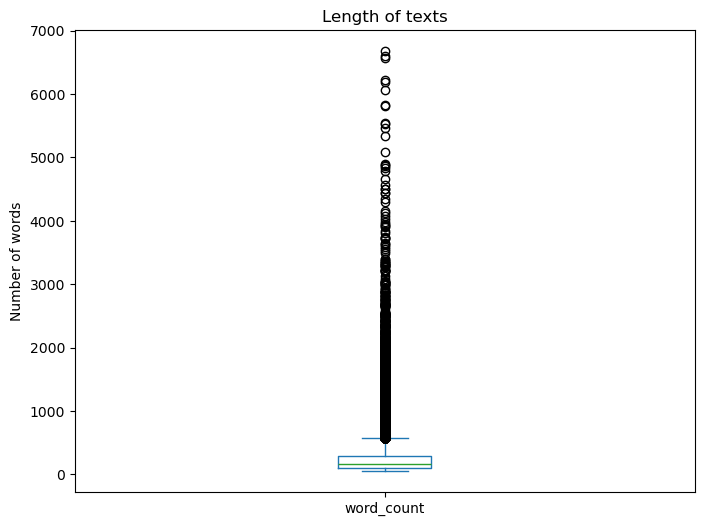

In [18]:
average_length = complete_data['word_count'].mean()
print(f"Average number of words: {average_length}")

# Create a boxplot of the word counts
plt.figure(figsize=(8, 6))
submissions_filtered3["word_count"].plot(kind='box')
plt.title('Length of texts')
plt.ylabel('Number of words')
plt.show()

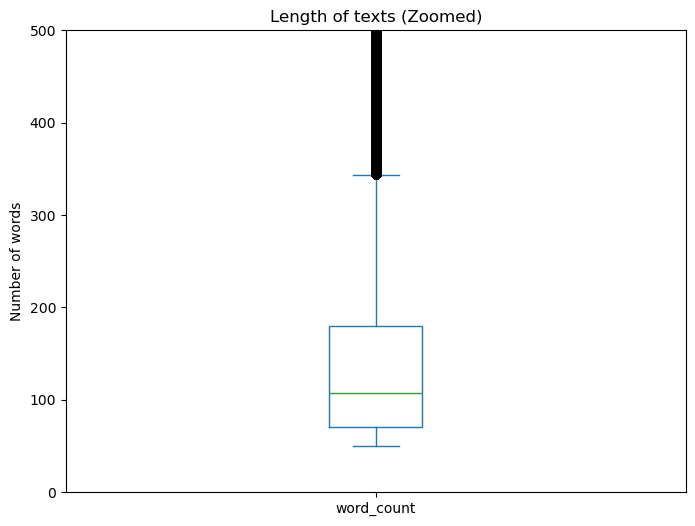

In [19]:
# Take a closer look
plt.figure(figsize=(8, 6))
complete_data["word_count"].plot(kind='box')
plt.title('Length of texts (Zoomed)')
plt.ylabel('Number of words')
plt.ylim(0, 500)  
plt.show()

### Year of publication distribution

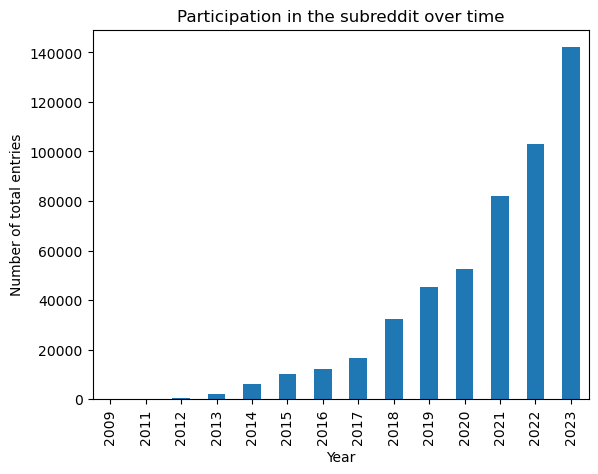

In [20]:
year_counts = complete_data['year'].value_counts().sort_index()

year_counts.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of total entries')
plt.title('Participation in the subreddit over time')
plt.show()

### Observe number of participants in the forum

In [21]:
authors = complete_data["author"]
print("{} unique authors".format(len(set(authors))))


166258 unique authors


## Export final df

In [22]:
#Exclude title and body columns from final data as they create some issues with the parsing of
#the CSV. Also delete in_english column since it won't be useful anymore
final_data = complete_data.drop(["title", "body", "in_english"], axis=1, inplace=False)

In [23]:
final_data.to_csv('data/cleaned_data1.csv')

Ensure correct parsing

In [24]:
saved_csv = pd.read_csv("data/cleaned_data1.csv")

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_4643/4222113242.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  saved_csv = pd.read_csv("data/cleaned_data1.csv")


In [25]:
print(final_data.shape)
print(saved_csv.shape)

(505272, 12)
(505272, 13)
